# Iteration 30: Bug fix

## Plain English Summary

After the interface to the model had been built we conducting some informal experimentation with the model. We found that our testing had omitted testing plotting code in experiments where the stroke arrival rate was very high resulting in high occupancies.  Our prompts to the LLM had "hard coded" up to 30 beds in the probability of delay and occupancy plots.

We identified that three minor changes needed to occur to allow for dynamic plotting: two in the the model code and one in the calling streamlit script.  We implemented this via three very simple LLM prompts.

## Notebook imports

In [1]:
from IPython.display import Markdown, display, HTML
import math
import statistics
from sim_tools.distributions import Lognormal

## LLM Prompt 1 <a class="anchor" id="llm_prompt"></a>

In [2]:
display(Markdown("inputs/31_iteration.md"))

The functions `combine_pdelay_results` and `combine_occup_results` contain a bug when the number of unique values is greater than 30.  Fix the bug so that the functions can handle more or less than 30 unique values, but still ensure that all arrays are of the same length.

display all code in the modified functions.

```python
def combine_pdelay_results(rep_results):
    result_list_asu = []
    result_list_rehab = []
    
    for rep_result in rep_results:
        prob_delay_asu = rep_result['prob_delay_asu']
        unique_vals_asu = rep_result['unique_vals_asu']
        
        min_occupancy_asu = min(unique_vals_asu)
        
        new_array_asu = np.zeros(30)
        for i, val in zip(unique_vals_asu, prob_delay_asu):
            new_array_asu[i] = val
        
        new_array_asu[:min_occupancy_asu] = 1.0
        
        result_list_asu.append(new_array_asu)
        
        prob_delay_rehab = rep_result['prob_delay_rehab']
        unique_vals_rehab = rep_result['unique_vals_rehab']
        
        min_occupancy_rehab = min(unique_vals_rehab)
        
        new_array_rehab = np.zeros(30)
        for i, val in zip(unique_vals_rehab, prob_delay_rehab):
            new_array_rehab[i] = val
        
        new_array_rehab[:min_occupancy_rehab] = 1.0
        
        result_list_rehab.append(new_array_rehab)
    
    return np.array(result_list_asu), np.array(result_list_rehab)



def combine_occup_results(rep_results):
    result_list_asu = []
    result_list_rehab = []
    
    for rep_result in rep_results:
        relative_freq_asu = rep_result['relative_freq_asu']
        unique_vals_asu = rep_result['unique_vals_asu']
        
        new_array_asu = np.zeros(30)
        for i, val in zip(unique_vals_asu, relative_freq_asu):
            new_array_asu[i] = val
        
        result_list_asu.append(new_array_asu)
        
        relative_freq_rehab = rep_result['relative_freq_rehab']
        unique_vals_rehab = rep_result['unique_vals_rehab']
        
        new_array_rehab = np.zeros(30)
        for i, val in zip(unique_vals_rehab, relative_freq_rehab):
            new_array_rehab[i] = val
        
        result_list_rehab.append(new_array_rehab)
    
    return np.array(result_list_asu), np.array(result_list_rehab)

```

## LLM Prompt 2

In [3]:
display(Markdown("inputs/31a_iteration.md"))

The functions `occupancy_plot` and `prob_delay_plot` contain a bug when the number of unique values is greater than 30.  Fix the bug so that the functions can handle more or less than 30 unique values.

display all code in the modified functions.


```python
def occupancy_plot(relative_frequency, unique_values, x_label="No. people in ASU", fig_size=(12, 5)):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.bar(unique_values, relative_frequency, align='center', alpha=0.7)
    ax.set_xticks(np.arange(0, 31, 1))
    ax.set_xlabel(x_label)
    ax.set_ylabel('Relative Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.title('Occupancy Relative Frequency Distribution')
    plt.show()
    return fig, ax

def prob_delay_plot(prob_delay, unique_values, x_label="No. acute beds available", fig_size=(12, 5)):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.step(unique_values, prob_delay, where='post')
    ax.set_xticks(np.arange(0, 31, 1))
    ax.set_xlabel(x_label)
    ax.set_ylabel('Probability of Delay')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.title('Probability of Delay Distribution')
    plt.show()
    return fig, ax
```

## LLM Prompt 3

In [4]:
display(Markdown("inputs/31b_iteration.md"))

The streamlit script contains a bug when the length of the results arrays passed to the plotting functions is more or less than 30.  Fix the script so that the a dynamic size arange is passed. Show all code in the script.

## Diff of notebooks. <a class="anchor" id="diff"></a>

N/A

## Date and time of input to LLM

> 1500 25th June 2024

## Observations on the LLM Output

* The LLM coped very well with simple refactoring commands that we issued. The fixes worked first time.

## Sources reported by the LLM

* None reported at time of generation.

## Code carried over

* `normal_moments_from_lognormal` - a function for converting moments of a lognormal to underlying normal
*  `audit_acute_occupancy` - code to observe the ASU occupancy at specified time intervals.
*  `calculate_occupancy_frequencies` - calculate relative frequencies of occupancy observations
*  `calculate_prob_delay`
*  `AcuteStrokeUnit`
*  `RehabilitationUnit`
*  `single_run` - code that runs the full model ASU+REHAB
*  `multiple_replications`
*  `summary_table`
*  `Experiment`

## Model code <a class="anchor" id="model_code"></a>

### Imports

In [5]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### lognormal function

In [6]:
# External function to convert Lognormal moments to Normal moments
def normal_moments_from_lognormal(mean, std_dev):
    phi = np.sqrt(std_dev ** 2 + mean ** 2)
    mu = np.log(mean ** 2 / np.sqrt(std_dev ** 2 + mean ** 2))
    sigma = np.sqrt(np.log(phi ** 2 / mean ** 2))
    return mu, sigma

### Experiment class

In [7]:
class Experiment:
    def __init__(self, stroke_mean=1.2, tia_mean=9.3, neuro_mean=3.6, other_mean=3.2,
                 rehab_mean=7.4, rehab_std_dev=8.6, esd_mean=4.6, esd_std_dev=4.8,
                 other_dest_mean=7.0, other_dest_std_dev=8.7,
                 tia_dest_mean=1.8, tia_dest_std_dev=5.0,
                 neuro_dest_mean=4.0, neuro_dest_std_dev=5.0,
                 other_dest_mean_2=3.8, other_dest_std_dev_2=5.2,
                 results_collection_period=1825, trace=False,
                 rehab_stroke_iat=21.8, rehab_neuro_iat=31.7, rehab_other_iat=28.6,
                 rehab_stroke_esd_mean=30.3, rehab_stroke_esd_std_dev=23.1,
                 rehab_stroke_other_mean=28.4, rehab_stroke_other_std_dev=27.2,
                 rehab_neuro_mean=27.6, rehab_neuro_std_dev=28.4,
                 rehab_other_mean=16.1, rehab_other_std_dev=14.1,
                 rehab_stroke_post_destination_prob=[0.4, 0.6],
                 rehab_neuro_post_destination_prob=[0.09, 0.91],
                 rehab_other_post_destination_prob=[0.12, 0.88],
                 warm_up=1095, random_number_set=0):
        
        self.stroke_interarrival_mean = stroke_mean
        self.tia_interarrival_mean = tia_mean
        self.neuro_interarrival_mean = neuro_mean
        self.other_interarrival_mean = other_mean
        self.rehab_mean = rehab_mean
        self.rehab_std_dev = rehab_std_dev
        self.esd_mean = esd_mean
        self.esd_std_dev = esd_std_dev
        self.other_dest_mean = other_dest_mean
        self.other_dest_std_dev = other_dest_std_dev
        self.tia_dest_mean = tia_dest_mean
        self.tia_dest_std_dev = tia_dest_std_dev
        self.neuro_dest_mean = neuro_dest_mean
        self.neuro_dest_std_dev = neuro_dest_std_dev
        self.other_dest_mean_2 = other_dest_mean_2
        self.other_dest_std_dev_2 = other_dest_std_dev_2
        self.results_collection_period = results_collection_period
        self.warm_up = warm_up  # New member variable for warm-up period
        self.trace = trace
        self.asu_occupancy = []  # List to store ASU occupancy data
        self.rehab_occupancy = []  # List to store Rehabilitation Unit occupancy data

        
        # New parameters for RehabilitationUnit treatment distributions and probabilities
        self.rehab_stroke_iat = rehab_stroke_iat
        self.rehab_neuro_iat = rehab_neuro_iat
        self.rehab_other_iat = rehab_other_iat
        
        self.rehab_stroke_esd_mean = rehab_stroke_esd_mean
        self.rehab_stroke_esd_std_dev = rehab_stroke_esd_std_dev
        
        self.rehab_stroke_other_mean = rehab_stroke_other_mean
        self.rehab_stroke_other_std_dev = rehab_stroke_other_std_dev
        
        self.rehab_neuro_mean = rehab_neuro_mean
        self.rehab_neuro_std_dev = rehab_neuro_std_dev
        
        self.rehab_other_mean = rehab_other_mean
        self.rehab_other_std_dev = rehab_other_std_dev
        
        # Probabilities for post-rehab destination sampling for each patient type in RehabilitationUnit
        self.rehab_stroke_post_destination_prob = rehab_stroke_post_destination_prob
        self.rehab_neuro_post_destination_prob = rehab_neuro_post_destination_prob
        self.rehab_other_post_destination_prob = rehab_other_post_destination_prob

        # Call the setup_streams method with the provided random_number_set parameter
        self.setup_streams(random_number_set)

    def reset_kpi(self):
        """Reset the occupancy lists to empty."""
        self.asu_occupancy.clear()
        self.rehab_occupancy.clear()

    def setup_streams(self, random_number_set):
      """Setup random number streams based on the provided seed."""
      # Create an empty list to store random number generator objects
      self.streams = []
      
      # Create a numpy random default_rng generator object using random_number_set as a seed.
      rng_seed_generator = np.random.default_rng(random_number_set)
      
      # Generate a list of 25 random integer seeds sampled from a uniform distribution with lower bound 0 and upper bound equal to the system's maximum 64-bit integer size.
      seeds = rng_seed_generator.integers(0, np.iinfo(np.int64).max, size=25)
      
      # Loop through the seeds and create a new numpy random default_rng object for each seed and append it to the streams list.
      for seed in seeds:
          rng_obj = np.random.default_rng(seed)
          self.streams.append(rng_obj)

### Acute stroke unit class

In [8]:
class AcuteStrokeUnit:
    def __init__(self, env, experiment, rehab_unit):
        self.env = env
        self.experiment = experiment
        self.rehab_unit = rehab_unit
        self.patient_count = 0
        self.occupancy = 0

    def stroke_acute_treatment(self, post_asu_destination):
        if post_asu_destination == "Rehab":
            mu, sigma = normal_moments_from_lognormal(self.experiment.rehab_mean, self.experiment.rehab_std_dev)
            length_of_stay = self.experiment.streams[0].lognormal(mean=mu, sigma=sigma)
        elif post_asu_destination == "ESD":
            mu, sigma = normal_moments_from_lognormal(self.experiment.esd_mean, self.experiment.esd_std_dev)
            length_of_stay = self.experiment.streams[1].lognormal(mean=mu, sigma=sigma)
        else:
            mu, sigma = normal_moments_from_lognormal(self.experiment.other_dest_mean, self.experiment.other_dest_std_dev)
            length_of_stay = self.experiment.streams[2].lognormal(mean=mu, sigma=sigma)
        
        self.occupancy += 1  # Increment occupancy when a patient arrives
        yield self.env.timeout(length_of_stay)
        if self.experiment.trace:
            print(f"Stroke patient {self.patient_count} finished treatment at {self.env.now} days")
        self.occupancy -= 1  # Decrement occupancy at the end of treatment
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.env.process(self.rehab_unit.stroke_rehab_treatment())

    def tia_acute_treatment(self, post_asu_destination):
        mu, sigma = normal_moments_from_lognormal(self.experiment.tia_dest_mean, self.experiment.tia_dest_std_dev)
        length_of_stay = self.experiment.streams[3].lognormal(mean=mu, sigma=sigma)
        
        self.occupancy += 1  # Increment occupancy when a patient arrives
        yield self.env.timeout(length_of_stay)
        if self.experiment.trace:
            print(f"TIA patient {self.patient_count} finished treatment at {self.env.now} days")
        self.occupancy -= 1  # Decrement occupancy at the end of treatment
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.env.process(self.rehab_unit.tia_rehab_treatment())

    def neuro_acute_treatment(self, post_asu_destination):
        mu, sigma = normal_moments_from_lognormal(self.experiment.neuro_dest_mean, self.experiment.neuro_dest_std_dev)
        length_of_stay = self.experiment.streams[4].lognormal(mean=mu, sigma=sigma)
        
        self.occupancy += 1  # Increment occupancy when a patient arrives
        yield self.env.timeout(length_of_stay)
        if self.experiment.trace:
            print(f"Complex Neuro patient {self.patient_count} finished treatment at {self.env.now} days")
        self.occupancy -= 1  # Decrement occupancy at the end of treatment
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.env.process(self.rehab_unit.neuro_rehab_treatment())

    def other_acute_treatment(self, post_asu_destination):
        mu, sigma = normal_moments_from_lognormal(self.experiment.other_dest_mean_2, self.experiment.other_dest_std_dev_2)
        length_of_stay = self.experiment.streams[5].lognormal(mean=mu, sigma=sigma)
        
        self.occupancy += 1  # Increment occupancy when a patient arrives
        yield self.env.timeout(length_of_stay)
        if self.experiment.trace:
            print(f"Other patient {self.patient_count} finished treatment at {self.env.now} days")
        self.occupancy -= 1  # Decrement occupancy at the end of treatment
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.env.process(self.rehab_unit.other_rehab_treatment())

    def stroke_patient_generator(self):
        while True:
            interarrival_time = self.experiment.streams[6].exponential(self.experiment.stroke_interarrival_mean)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            post_asu_destination = self.experiment.streams[7].choice(["Rehab", "ESD", "Other"], p=[0.24, 0.13, 0.63])
            if self.experiment.trace:
                print(f"Stroke patient {self.patient_count} arrived at {self.env.now} days and will go to {post_asu_destination}")
            self.env.process(self.stroke_acute_treatment(post_asu_destination))

    def tia_patient_generator(self):
        while True:
            interarrival_time = self.experiment.streams[8].exponential(self.experiment.tia_interarrival_mean)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            post_asu_destination = self.experiment.streams[9].choice(["Rehab", "ESD", "Other"], p=[0.01, 0.01, 0.98])
            if self.experiment.trace:
                print(f"TIA patient {self.patient_count} arrived at {self.env.now} days and will go to {post_asu_destination}")
            self.env.process(self.tia_acute_treatment(post_asu_destination))

    def neuro_patient_generator(self):
        while True:
            interarrival_time = self.experiment.streams[10].exponential(self.experiment.neuro_interarrival_mean)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            post_asu_destination = self.experiment.streams[11].choice(["Rehab", "ESD", "Other"], p=[0.11, 0.05, 0.84])
            if self.experiment.trace:
                print(f"Complex Neuro patient {self.patient_count} arrived at {self.env.now} days and will go to {post_asu_destination}")
            self.env.process(self.neuro_acute_treatment(post_asu_destination))

    def other_patient_generator(self):
        while True:
            interarrival_time = self.experiment.streams[12].exponential(self.experiment.other_interarrival_mean)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            post_asu_destination = self.experiment.streams[13].choice(["Rehab", "ESD", "Other"], p=[0.05, 0.10, 0.85])
            if self.experiment.trace:
                print(f"Other patient {self.patient_count} arrived at {self.env.now} days and will go to {post_asu_destination}")
            self.env.process(self.other_acute_treatment(post_asu_destination))

### Rehabilitation Unit class <a class="anchor" id="iteration_code_a"></a>

In [9]:
class RehabilitationUnit:
    def __init__(self, env, experiment):
        self.env = env
        self.experiment = experiment
        self.patient_count = 0
        self.stroke_count = 0
        self.neuro_count = 0
        self.other_count = 0
        self.occupancy = 0

    def stroke_patient_generator(self):
        while True:
            interarrival_time = self.experiment.streams[14].exponential(self.experiment.rehab_stroke_iat)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            self.stroke_count += 1
            if self.experiment.trace:
                print(f"Stroke patient {self.patient_count} arrived at Rehabilitation Unit at {self.env.now} days")
            self.occupancy += 1
            self.env.process(self.stroke_rehab_treatment())

    def neuro_patient_generator(self):
        while True:
            interarrival_time = self.experiment.streams[15].exponential(self.experiment.rehab_neuro_iat)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            self.neuro_count += 1
            if self.experiment.trace:
                print(f"Complex Neurological patient {self.patient_count} arrived at Rehabilitation Unit at {self.env.now} days")
            self.occupancy += 1
            self.env.process(self.neuro_rehab_treatment())

    def other_patient_generator(self):
        while True:
            interarrival_time = self.experiment.streams[16].exponential(self.experiment.rehab_other_iat)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            self.other_count += 1
            if self.experiment.trace:
                print(f"Other patient {self.patient_count} arrived at Rehabilitation Unit at {self.env.now} days")
            self.occupancy += 1
            self.env.process(self.other_rehab_treatment())

    def tia_rehab_treatment(self):
        post_rehab_destination = self.experiment.streams[17].choice([0, 100])
        mu, sigma = normal_moments_from_lognormal(18.7, 23.5)
        
        length_of_stay = self.experiment.streams[18].lognormal(mean=mu, sigma=sigma)
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.trace:
            print(f"TIA patient {self.patient_count} finished treatment at Rehabilitation Unit at {self.env.now} days")
        
        self.occupancy -= 1

    def stroke_rehab_treatment(self):
        post_rehab_destination = self.experiment.streams[19].choice(["ESD", "Other"], p=self.experiment.rehab_stroke_post_destination_prob)
        if post_rehab_destination == "ESD":
            mu, sigma = normal_moments_from_lognormal(self.experiment.rehab_stroke_esd_mean, self.experiment.rehab_stroke_esd_std_dev)
        else:
            mu, sigma = normal_moments_from_lognormal(self.experiment.rehab_stroke_other_mean, self.experiment.rehab_stroke_other_std_dev)
        
        length_of_stay = self.experiment.streams[20].lognormal(mean=mu, sigma=sigma)
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.trace:
            print(f"Stroke patient {self.patient_count} finished treatment at Rehabilitation Unit at {self.env.now} days")
        
        self.occupancy -= 1

    def neuro_rehab_treatment(self):
        post_rehab_destination = self.experiment.streams[21].choice(["ESD", "Other"], p=self.experiment.rehab_neuro_post_destination_prob)
        mu, sigma = normal_moments_from_lognormal(self.experiment.rehab_neuro_mean, self.experiment.rehab_neuro_std_dev)
        
        length_of_stay = self.experiment.streams[22].lognormal(mean=mu, sigma=sigma)
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.trace:
            print(f"Complex Neurological patient {self.patient_count} finished treatment at Rehabilitation Unit at {self.env.now} days")
        
        self.occupancy -= 1

    def other_rehab_treatment(self):
        post_rehab_destination = self.experiment.streams[23].choice(["ESD", "Other"], p=self.experiment.rehab_other_post_destination_prob)
        mu, sigma = normal_moments_from_lognormal(self.experiment.rehab_other_mean, self.experiment.rehab_other_std_dev)
        
        length_of_stay = self.experiment.streams[24].lognormal(mean=mu, sigma=sigma)
        
        yield self.env.timeout(length_of_stay)
        
        if self.experiment.trace:
            print(f"Other patient {self.patient_count} finished treatment at Rehabilitation Unit at {self.env.now} days")
        
        self.occupancy -= 1

### Occupancy auditing function

In [10]:
def audit_acute_occupancy(env, first_interval, audit_interval, asu, experiment):
    yield env.timeout(first_interval)
    while True:
        experiment.asu_occupancy.append(asu.occupancy)
        yield env.timeout(audit_interval)

In [11]:
def audit_rehab_occupancy(env, first_interval, audit_interval, rehab_unit, experiment):
    yield env.timeout(first_interval)
    while True:
        experiment.rehab_occupancy.append(rehab_unit.occupancy)
        yield env.timeout(audit_interval)

### Occupancy post-processing code

In [12]:
def calculate_occupancy_frequencies(data):
    unique_values, counts = np.unique(data, return_counts=True)
    relative_frequency = counts / len(data)
    cumulative_frequency = np.cumsum(relative_frequency)
    return relative_frequency, cumulative_frequency, unique_values

> This code was fixed in iteration 31b

In [13]:
def occupancy_plot(relative_frequency, unique_values, x_label="No. people in ASU", fig_size=(12, 5)):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.bar(unique_values, relative_frequency, align='center', alpha=0.7)
    
    # Dynamically set x-axis ticks based on the range of unique values
    max_value = max(unique_values)
    tick_step = max(1, max_value // 10)  # Ensure at least 10 ticks, but not more than the number of unique values
    ax.set_xticks(np.arange(0, max_value + 1, tick_step))
    
    ax.set_xlabel(x_label)
    ax.set_ylabel('Relative Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.title('Occupancy Relative Frequency Distribution')
    plt.tight_layout()
    return fig, ax

### Probability of deplay post-processing code

In [14]:
def calculate_prob_delay(relative_frequencies, cumulative_frequencies):
    prob_delay = np.array(relative_frequencies) / np.array(cumulative_frequencies)
    return prob_delay

> This code was fixed in iteration 31b

In [15]:
def prob_delay_plot(prob_delay, unique_values, x_label="No. acute beds available", fig_size=(12, 5)):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.step(unique_values, prob_delay, where='post')
    
    # Dynamically set x-axis ticks based on the range of unique values
    max_value = max(unique_values)
    tick_step = max(1, max_value // 10)  # Ensure at least 10 ticks, but not more than the number of unique values
    ax.set_xticks(np.arange(0, max_value + 1, tick_step))
    
    ax.set_xlabel(x_label)
    ax.set_ylabel('Probability of Delay')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.title('Probability of Delay Distribution')
    plt.tight_layout()
    return fig, ax

### Function to perform a single run of ASU+REHAB

In [16]:
def single_run(experiment):
    experiment.reset_kpi()
    
    env = simpy.Environment()
    
    # Create an instance of RehabilitationUnit and AcuteStrokeUnit with the Experiment parameters
    rehab_unit = RehabilitationUnit(env, experiment)
    acu_experiment = AcuteStrokeUnit(env, experiment, rehab_unit)
    
    # Initialize patient generators as simpy processes in both units
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
    
    # Initialize audit functions for both units to record occupancy at intervals
    env.process(audit_rehab_occupancy(env, experiment.warm_up, 1, rehab_unit, experiment))
    env.process(audit_acute_occupancy(env, experiment.warm_up, 1, acu_experiment, experiment))
    
    # Run the simulation for the specified period (results_collection_period + warm_up)
    env.run(until=experiment.results_collection_period + experiment.warm_up)
    
    # Calculate occupancy frequencies and probability of delay for both units and return the results in a dictionary
    relative_freq_asu, cumulative_freq_asu, unique_vals_asu = calculate_occupancy_frequencies(experiment.asu_occupancy)
    relative_freq_rehab, cumulative_freq_rehab, unique_vals_rehab = calculate_occupancy_frequencies(experiment.rehab_occupancy)
    
    prob_delay_asu = calculate_prob_delay(relative_freq_asu, cumulative_freq_asu)
    prob_delay_rehab = calculate_prob_delay(relative_freq_rehab, cumulative_freq_rehab)
    
    return {
            'relative_freq_asu': relative_freq_asu,
            'prob_delay_asu': prob_delay_asu,
            'unique_vals_asu': unique_vals_asu,
            'relative_freq_rehab': relative_freq_rehab,
            'prob_delay_rehab': prob_delay_rehab,
            'unique_vals_rehab': unique_vals_rehab 
           }

### Multiple Replication function

In [17]:
def multiple_replications(experiment_instance, num_replications=5):
    rep_results = []
    for replication_number in range(num_replications):
        # Call Experiment setup_streams method before running each replication and pass the current replication number as an argument
        experiment_instance.setup_streams(replication_number)
        
        rep_results.append(single_run(experiment_instance))
    return rep_results

### Functions to combine replication results

> The two combine functions were modified and fixed in iteration 31a

In [18]:
def combine_pdelay_results(rep_results):
    """Combine the probability of delay results from multiple simulation runs.

    Parameters:
    - results (list): A list of dictionaries, each containing the occupancy
    frequencies and probability of delay for both the Acute Stroke Unit and
    the Rehabilitation Unit from a single simulation run.
    """
    result_list_asu = []
    result_list_rehab = []
    
    max_occupancy_asu = max(max(rep['unique_vals_asu']) for rep in rep_results)
    max_occupancy_rehab = max(max(rep['unique_vals_rehab']) for rep in rep_results)
    
    for rep_result in rep_results:
        prob_delay_asu = rep_result['prob_delay_asu']
        unique_vals_asu = rep_result['unique_vals_asu']
        
        min_occupancy_asu = min(unique_vals_asu)
        
        new_array_asu = np.zeros(max_occupancy_asu + 1)
        for i, val in zip(unique_vals_asu, prob_delay_asu):
            new_array_asu[i] = val
        
        new_array_asu[:min_occupancy_asu] = 1.0
        
        result_list_asu.append(new_array_asu)
        
        prob_delay_rehab = rep_result['prob_delay_rehab']
        unique_vals_rehab = rep_result['unique_vals_rehab']
        
        min_occupancy_rehab = min(unique_vals_rehab)
        
        new_array_rehab = np.zeros(max_occupancy_rehab + 1)
        for i, val in zip(unique_vals_rehab, prob_delay_rehab):
            new_array_rehab[i] = val
        
        new_array_rehab[:min_occupancy_rehab] = 1.0
        
        result_list_rehab.append(new_array_rehab)
    
    return np.array(result_list_asu), np.array(result_list_rehab)

In [19]:
def combine_occup_results(rep_results):
    """Combine the occupancy frequency results from multiple simulation runs.

    Parameters:
    - results (list): A list of dictionaries, each containing the occupancy
    frequencies and probability of delay for both the Acute Stroke Unit
    and the Rehabilitation Unit from a single simulation run.
    """
    result_list_asu = []
    result_list_rehab = []
    
    max_occupancy_asu = max(max(rep['unique_vals_asu']) for rep in rep_results)
    max_occupancy_rehab = max(max(rep['unique_vals_rehab']) for rep in rep_results)
    
    for rep_result in rep_results:
        relative_freq_asu = rep_result['relative_freq_asu']
        unique_vals_asu = rep_result['unique_vals_asu']
        
        new_array_asu = np.zeros(max_occupancy_asu + 1)
        for i, val in zip(unique_vals_asu, relative_freq_asu):
            new_array_asu[i] = val
        
        result_list_asu.append(new_array_asu)
        
        relative_freq_rehab = rep_result['relative_freq_rehab']
        unique_vals_rehab = rep_result['unique_vals_rehab']
        
        new_array_rehab = np.zeros(max_occupancy_rehab + 1)
        for i, val in zip(unique_vals_rehab, relative_freq_rehab):
            new_array_rehab[i] = val
        
        result_list_rehab.append(new_array_rehab)
    
    return np.array(result_list_asu), np.array(result_list_rehab)

In [20]:
def mean_results(rep_results):
    return np.mean(rep_results, axis=0)

### Tabular results for p(delay)

In [21]:
def summary_table(mean_pdelay, min_beds, max_beds, bed_type):
    sliced_mean_pdelay = mean_pdelay[min_beds:max_beds+1]
    inv_mean_pdelay = 1 / sliced_mean_pdelay
    inv_mean_pdelay_rounded = np.floor(inv_mean_pdelay).astype(int)
    
    df_summary_table = pd.DataFrame({
        'p(delay)': sliced_mean_pdelay.round(2),
        '1 in every n patients delayed': inv_mean_pdelay_rounded
    }, index=pd.Index(range(min_beds, max_beds+1), name="No. " + bed_type + " beds"))
    
    return df_summary_table

> The manual script was modified by a tester in iteration 31

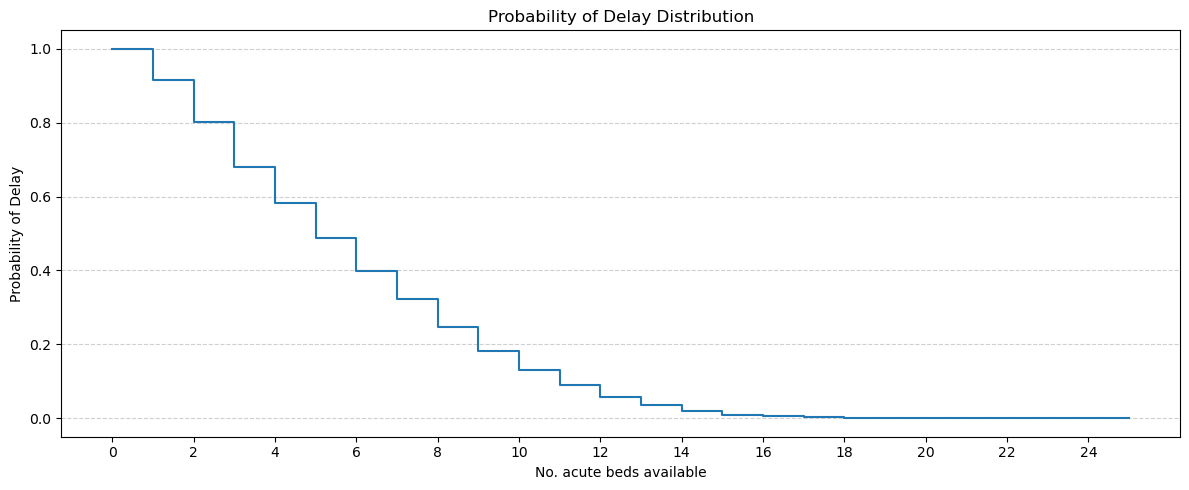

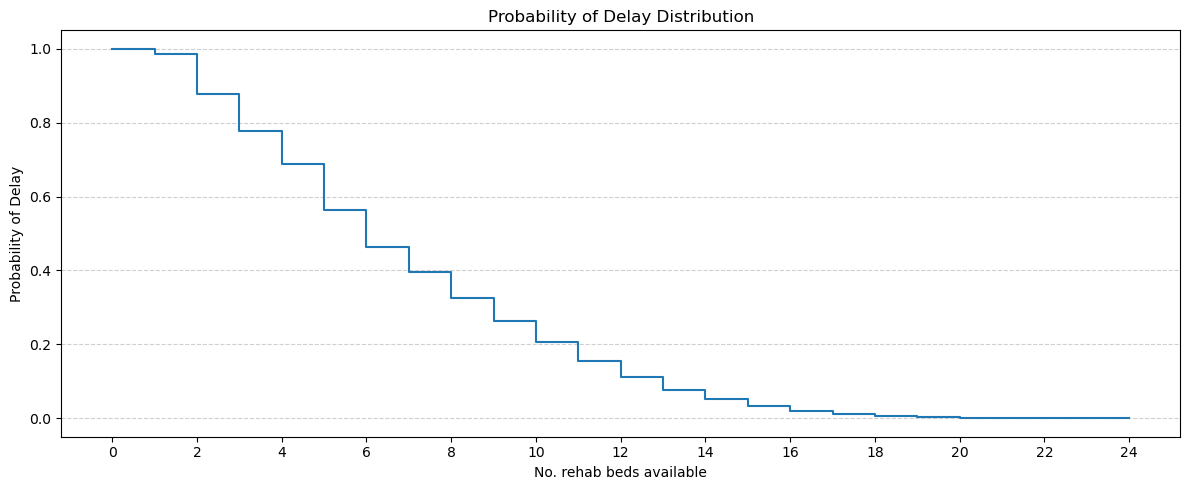

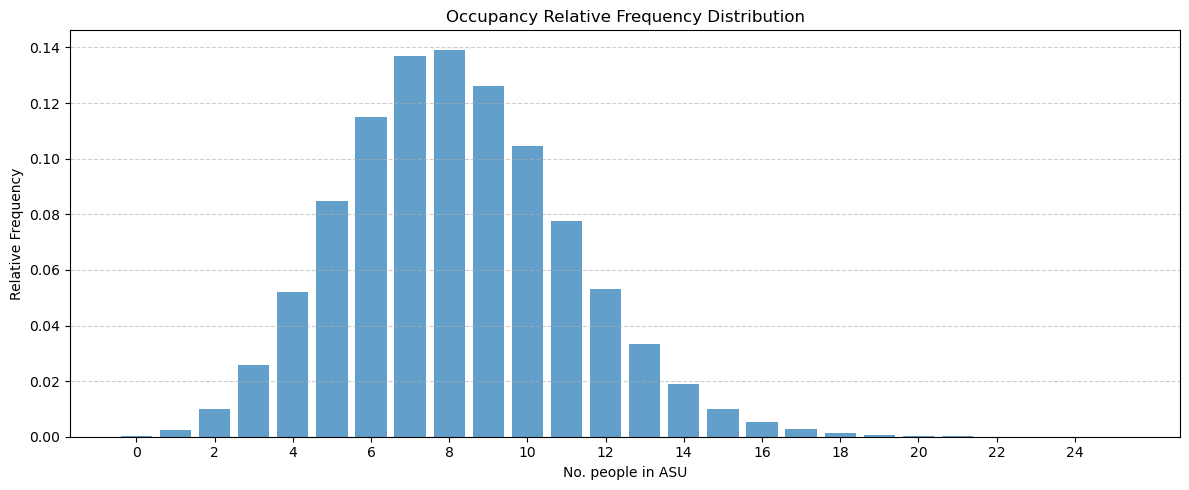

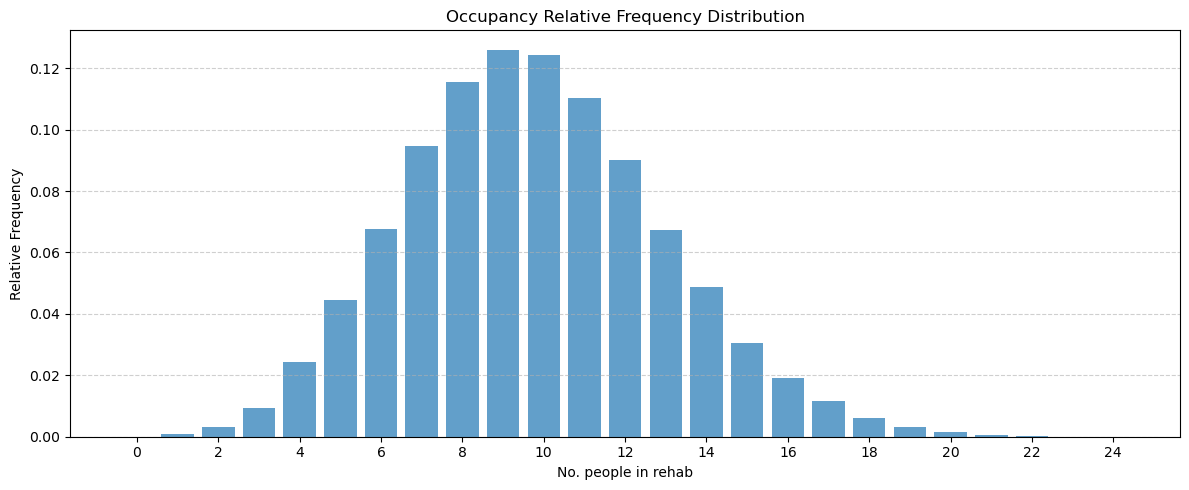

In [22]:
# Create an instance of Experiment  (default params, default warm-up and rcp).
experiment = Experiment()

# run multiple replications
rep_results = multiple_replications(experiment, 100)

# combine results and take the mean 
pd_asu, pd_rehab = combine_pdelay_results(rep_results)
rel_asu, rel_rehab = combine_occup_results(rep_results)
mean_pd_asu, mean_pd_rehab = mean_results(pd_asu), mean_results(pd_rehab)
mean_rel_asu, mean_rel_rehab = mean_results(rel_asu), mean_results(rel_rehab)

# prob delay plots 
prob_delay_plot(mean_pd_asu, np.arange(0, len(mean_pd_asu)))
prob_delay_plot(mean_pd_rehab, np.arange(0, len(mean_pd_rehab)), "No. rehab beds available")

# prob occupancy plots
occupancy_plot(mean_rel_asu, np.arange(0, len(mean_rel_asu)))
occupancy_plot(mean_rel_rehab, np.arange(0, len(mean_rel_rehab)), "No. people in rehab")

## tabular results
# acute
df_acute = summary_table(mean_pd_asu, 9, 14, "acute")
df_rehab = summary_table(mean_pd_rehab, 10, 16, "rehab")


In [23]:
df_acute

,p(delay),1 in every n patients delayed
No. acute beds,,
9,0.18,5
10,0.13,7
11,0.09,11
12,0.06,17
13,0.03,28
14,0.02,51


In [24]:
df_rehab

,p(delay),1 in every n patients delayed
No. rehab beds,,
10,0.21,4
11,0.15,6
12,0.11,8
13,0.08,12
14,0.05,18
15,0.03,31
16,0.02,50


# Interface code 

> This code was modified in iteration 31c

```python
import streamlit as st
import numpy as np
from stroke_rehab_model import (
    Experiment, multiple_replications, combine_pdelay_results, 
    combine_occup_results, mean_results, prob_delay_plot, 
    occupancy_plot, summary_table
)

def main():
    st.title("A modelling tool for capacity planning in acute and community stroke services")

    st.write("This model is a recreation of the model reported in a published academic study.")

    st.write("Original study citation:")
    st.write("Monks T, Worthington D, Allen M, Pitt M, Stein K, James MA. A modelling tool for capacity planning in acute and community stroke services. BMC Health Serv Res. 2016 Sep 29;16(1):530. doi: 10.1186/s12913-016-1789-4. PMID: 27688152; PMCID: PMC5043535.")

    st.write("Link to the original study: [https://doi.org/10.1186/s12913-016-1789-4](https://doi.org/10.1186/s12913-016-1789-4)")

    # Sidebar for Experiment parameters
    st.sidebar.header("Simulation Parameters")

    # Inter-arrival rates
    st.sidebar.subheader("Inter-arrival Rates")
    stroke_mean = st.sidebar.number_input("Stroke patients", value=1.2, step=0.1)
    tia_mean = st.sidebar.number_input("TIA patients", value=9.3, step=0.1)
    neuro_mean = st.sidebar.number_input("Complex Neurological patients", value=3.6, step=0.1)
    other_mean = st.sidebar.number_input("Other patients", value=3.2, step=0.1)

    # Model control
    st.sidebar.subheader("Model Control")
    trace = st.sidebar.checkbox("Trace patients in simulation", value=False)
    warm_up = st.sidebar.number_input("Warm-up period", value=1095, step=1)

    # Number of replications
    num_replications = st.number_input("Number of replications", value=100, min_value=1, step=1)

    if st.button("Simulate"):
        with st.spinner("Please wait for results..."):
            # Create an instance of Experiment with user-defined parameters
            experiment = Experiment(
                stroke_mean=stroke_mean,
                tia_mean=tia_mean,
                neuro_mean=neuro_mean,
                other_mean=other_mean,
                trace=trace,
                warm_up=warm_up
            )

            # Run multiple replications
            rep_results = multiple_replications(experiment, num_replications)

            # Combine results and take the mean 
            pd_asu, pd_rehab = combine_pdelay_results(rep_results)
            rel_asu, rel_rehab = combine_occup_results(rep_results)
            mean_pd_asu, mean_pd_rehab = mean_results(pd_asu), mean_results(pd_rehab)
            mean_rel_asu, mean_rel_rehab = mean_results(rel_asu), mean_results(rel_rehab)

        # Display tables
        st.subheader("Acute Care Results")
        df_acute = summary_table(mean_pd_asu, 9, 14, "acute")
        st.table(df_acute)

        st.subheader("Rehabilitation Results")
        df_rehab = summary_table(mean_pd_rehab, 10, 16, "rehab")
        st.table(df_rehab)

        # Display plots
        st.subheader("Probability Delay Plots")
        fig_pd_asu, ax_pd_asu = prob_delay_plot(mean_pd_asu, np.arange(len(mean_pd_asu)))
        st.pyplot(fig_pd_asu)

        fig_pd_rehab, ax_pd_rehab = prob_delay_plot(mean_pd_rehab, np.arange(len(mean_pd_rehab)), "No. rehab beds available")
        st.pyplot(fig_pd_rehab)

        st.subheader("Occupancy Plots")
        fig_occ_asu, ax_occ_asu = occupancy_plot(mean_rel_asu, np.arange(len(mean_rel_asu)))
        st.pyplot(fig_occ_asu)

        fig_occ_rehab, ax_occ_rehab = occupancy_plot(mean_rel_rehab, np.arange(len(mean_rel_rehab)), "No. people in rehab")
        st.pyplot(fig_occ_rehab)

if __name__ == "__main__":
    main()

```

## Testing <a class="anchor" id="testing_code"></a>
* **Results processing 1**: code correctly calculates relative and cumulative frequencies
    * Expected result: for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
    * Actual result (PASS): for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
* **Results processing 2**: test that prob delay is calculated correctly.
    * Expected result: The probability of delay is [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
    * Actual result (PASS): The probability of delay is [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
* **Results collection test 1**: Test the result collection process for ASU collects ward occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Results collection test 2**: Test ASU ward occupancy data collected is in a sensible range.
    * Expected result: The type collected is int. The values are in the range 0 to 50 with sensible moments.
    * Actual result (PASS):  The type collected is int. The values are in the range 0 to 50 with sensible moments.
* **Results collection test 3**: Test the result collection process for REHAB collects unit occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Results collection test 4**: Test REHAB unit occupancy data collected is in a sensible range.
    * Expected result: The type collected is int. The values are in the range 0 to (10-15) with sensible moments.
    * Actual result (PASS):  The type collected is int. The values are 0 to (10-15) with sensible moments.
* **Results collection test 5**: **SYSTEM TEST**: Test the result collection process for ASU+REHAB collects ward occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Single run test**: **SYSTEM TEST**: Test that the `single_run` function returns a dictionary of results
  * Expected Result: len(run_results) == 6 and type(run_results) == dict
  * Actual Result (PASS): len(run_results) == 6 and type(run_results) == dict
* **Random number set test 1 (ASU)**: Test that ASU results are repeated each time the same random number set is used.
    * Expected Result: min, max, and mean occupancy is identical when model is run twice with same random numbers
    * Actual Result (PASS): min, max, and mean occupancy is identical when model is run twice with same random numbers
* **Random number set test 2 (SYSTEM TEST)**: Test that ASU+REHAB results are repeated each time the same random number set is used.
    * Expected Result: min, max, and mean occupancy is identical when model is run twice with same random numbers
    * Actual Result (PASS): min, max, and mean occupancy is identical when model is run twice with same random numbers
* **Warm-up Period Test**: Test warm-up works correctly for ASU+REHAB ward occupancy. Audit interval = 1 and Warm-up > 0
    * Expected result: The length of the occupancy data collection arrays is equal to the results collection period.
    * Actual result (PASS): The length of the occupancy data collection arrays is equal to the results collection period.
* **Suppress simulated trace**: Test that setting experiment.trace = False suppresses ASU output by default.
    * Expected result: The ASU model runs with no simulated log output
    * Actual result (PASS): The ASU model runs with no simulated log output
* **Suppress simulated trace 2**: Test that setting experiment.trace = False suppresses REHAB output by default.
    * Expected result: The REHAB model runs with no simulated log output
    * Actual result (PASS): The REHAB model runs with no simulated log output
* **Testing lognormal function**: Test that lognomal function correctly calculates the moments of the underlying normal dist.
    * Expected result: The LLM generated function and `sim-tools.distributions.Lognormal` perform the same conversion.
    * Actual results (PASS):  The functions generate the same values.
* **Extreme value test 1**: TIA, Complex Neuro, Other, have their inter-arrival time is set to $M$ a very large number
    * Expected result: The only type of patient to arrive to the model is "Stroke"
    * Actual result (PASS): The only type of patient to arrive to the model is "Stroke"
* **Extreme value test 2**: All patient types have have their inter-arrival time is set to $M$ a very large number
    * Expected result: No patients arrive to the model.
    * Actual result (PASS): No patients arrive to the model.
* **Different run length**: The run length of the model is set to 10 days.
    * Expected result: The model should runs no longer than 10 simulated time periods
    * Actual result (PASS): The model runs no longer than 10 simulated time periods
* **Extreme value test 3**: All patient types have have their mean length of stay time set to $M$ a very large number
    * Expected result: No patients depart the model (only arrivals seen in log)
    * Actual Results (PASS): No patients depart the model.
* **Extreme value test 4**: All patient types apart from stroke->rehab have have their mean length of stay time set to $M$ a very large number
    * Expected result: Only stroke patients depart the model (seen in log)
    * Actual Results (PASS): Only stroke patient depart the model.
* **Extreme value test 5**: In rehab, Complex Neuro, and Other, have their inter-arrival time is set to $M$ a very large number
    * Expected result: The only type of patient to arrive to the rehab model is "Stroke"
    * Actual result (PASS): The only type of patient to arrive to the rehab model is "Stroke"
* **Extreme value test 6**: In the rehab model, all patient types have have their inter-arrival time is set to $M$ a very large number
    * Expected result: No patients arrive to the model.
    * Actual result (PASS): No patients arrive to the model.
* **Extreme value test 7**: In the rehab model, all patient types have their length of stay means set to $M$ a very larger number.
    * Expected result: Patients arrive to the model as normal, but do not depart.
    * Actual result (PASS): Patients arrive to the model as normal, but do not depart.

### Results processing 1

Test that the code correctly calculates the relative and cumulative frequencies of a python list of integer values.

(PASS)

In [25]:
def result_processing_test_1(values, rel_expected, cum_expected):
    '''
    Test the `calculate_occupancy_frequencies` function works
    as expected.

    Expected result: relative frequencies and cumulative freqs
    are the same as expected values.

    Params:
    ------
    values: list
        list of values to test

    rel_expected: list
        list of floats - expected relative freqs

    cum_expected: list
        list of floats - expected cumulative freqs

    Returns:
    -------
    bool: does the model pass the test.
    '''
    rel, cum, unique = calculate_occupancy_frequencies(values)
    # use all close to allow for minor floating point differences.
    return (set(rel) == set(rel_expected)) and  np.allclose(np.array(cum_expected), cum)

In [26]:
result_processing_test_1(values=[1, 1, 1, 1, 2, 2, 2, 3, 3, 4],
                         rel_expected=[0.4, 0.3, 0.2, 0.1],
                         cum_expected=[0.4, 0.7, 0.9, 1.0])

True

### Results Processing test 2

Test that the calculation of the probability of delay is correct.

(PASS)

In [27]:
def result_processing_test_2(relative, cum, p_delay_expected):
    '''
    Test the probability of delay is calculated correctly.
    
    Params:
    ------
    relative: list
        list of floats - relative freqs

    cum: list
        list of floats - cumulative freqs

    Returns:
    -------
    bool: does the function pass the test.
    '''
    p_delay = calculate_prob_delay(relative, cum)
    # use all close to allow for minor floating point differences.
    return np.allclose(np.array(p_delay_expected), p_delay)

In [28]:
relative = [0.4, 0.3, 0.2, 0.1],
cum = [0.4, 0.7, 0.9, 1.0]
expected = [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
result = result_processing_test_2(relative, cum, expected)
result

True

### Results collection test 1

Test the optional results collection process works correctly.  The process should collect acute stroke occupancy every day

(PASS)

In [29]:
def results_collection_test1(audit_interval=1):
    '''
    Test the model collects acute stroke occupancy every day

    Expected result: len(experiment.occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arr~ival rates
    default_experiment_params = Experiment()

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    # MODIFIED iter 21
    env.process(audit_acute_occupancy(env, 1, audit_interval, acu_experiment, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    print(f'{len(default_experiment_params.asu_occupancy)=}')
    print(f'{env.now=}')
    return len(default_experiment_params.asu_occupancy) == (env.now - 1)

In [30]:
results_collection_test1()

len(default_experiment_params.asu_occupancy)=1824
env.now=1825


True

### Result collection test 2

(PASS)

In [31]:
def results_collection_test2(audit_interval=1):
    '''
    Test ASU ward occupancy data collected is in a sensible range.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 0 to 50 with sensible moments.

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    None
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arr~ival rates
    default_experiment_params = Experiment()

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    # MODIFIED iter 21
    env.process(audit_acute_occupancy(env, 1, audit_interval, acu_experiment, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    print(f'{min(default_experiment_params.asu_occupancy)=}')
    print(f'{max(default_experiment_params.asu_occupancy)=}')
    print(f'{statistics.fmean(default_experiment_params.asu_occupancy)=}')
    print([round(q, 1) for q in statistics.quantiles(default_experiment_params.asu_occupancy, n=10)])

In [32]:
results_collection_test2()

min(default_experiment_params.asu_occupancy)=1
max(default_experiment_params.asu_occupancy)=21
statistics.fmean(default_experiment_params.asu_occupancy)=8.296600877192983
[5.0, 6.0, 7.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]


### Results collection test 3

Test the optional results collection process works correctly for rehab.  The process should collect rehab unit occupancy every day.

(PASS)


In [33]:
def results_collection_test3(audit_interval=1):
    '''
    Test the model collects rehab occupancy every day

    Expected result: len(experiment.rehab_occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()

    # create experiment
    default_experiment = Experiment()
    
    rehab_unit = RehabilitationUnit(env, default_experiment)

    # Initialise the patient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
    
    # Initialise the audit of rehab occupancy as a simpy process with an interval of 1 day
    # MODIFIED iter 12
    env.process(audit_rehab_occupancy(env, 1, audit_interval, rehab_unit, default_experiment))
    
    # Run the model for the default run length in the experiment
    # MODIFIED iter 12
    env.run(until=default_experiment.results_collection_period)
    print(f'{len(default_experiment.rehab_occupancy)=}')
    print(f'{env.now=}')
    return len(default_experiment.rehab_occupancy) == (env.now - 1)

In [34]:
results_collection_test3()

len(default_experiment.rehab_occupancy)=1824
env.now=1825


True

### Results Collection Test 4

(PASS)

In [35]:
def results_collection_test4(audit_interval=1):
    '''
    Test REHAB ward occupancy data collected is in a sensible range.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 1 to [10-15] with sensible moments.

    Note this is when the Rehab unit is used independently
    with external arrivals only i.e. no transfers from ASU.

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    None
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # create experiment
    default_experiment = Experiment()
    
    rehab_unit = RehabilitationUnit(env, default_experiment)

    # Initialise the patient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
    
    # Initialise the audit of rehab occupancy as a simpy process with an interval of 1 day
    # MODIFIED iter 12
    env.process(audit_rehab_occupancy(env, 1, audit_interval, rehab_unit, default_experiment))
    
    # Run the model for the default run length in the experiment
    # MODIFIED iter 12
    env.run(until=default_experiment.results_collection_period)
    
    print(f'{min(default_experiment.rehab_occupancy)=}')
    print(f'{max(default_experiment.rehab_occupancy)=}')
    print(f'{statistics.fmean(default_experiment.rehab_occupancy)=}')
    print([round(q, 1) for q in statistics.quantiles(default_experiment.rehab_occupancy, n=10)])

In [36]:
results_collection_test4()

min(default_experiment.rehab_occupancy)=0
max(default_experiment.rehab_occupancy)=8
statistics.fmean(default_experiment.rehab_occupancy)=2.633771929824561
[1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 5.0]


### Results Collection Test 5 (SYSTEM TEST)

Test that when the models are linked that the occupancy is audited correctly.

In [37]:
def results_collection_test5(audit_interval=1):
    '''
    Test REHAB ward occupancy data collected is in a sensible range
    when it is connected to the ASU model.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 1 to [10-15] with sensible moments.

    Expected result: 
        len(experiment.asu_occupancy) == env.now - 1 AND
        len(experiment.rehab_occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # a default experiment
    default_experiment_params = Experiment()

    # create models
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # Initialize the pREHAB atient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())  

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    # MODIFIED iter 12
    env.process(audit_acute_occupancy(env, 1, audit_interval, acu_experiment, default_experiment_params))

    # Initialize the audit of rehab occupancy as a simpy process with an interval of 1 day
    # MODIFIED iter 12
    env.process(audit_rehab_occupancy(env, 1, audit_interval, rehab_unit, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period)

    # print info for debug
    print(f'{len(default_experiment_params.asu_occupancy)=}')
    print(f'{len(default_experiment_params.rehab_occupancy)=}')
    print(f'{env.now=}')

    # test
    return len(default_experiment_params.asu_occupancy) == (env.now - 1) and \
        len(default_experiment_params.rehab_occupancy) == (env.now - 1)

In [38]:
results_collection_test5()

len(default_experiment_params.asu_occupancy)=1824
len(default_experiment_params.rehab_occupancy)=1824
env.now=1825


True

### Results Collection Test 6 (SYSTEM TEST)


In [39]:
def results_collection_test6(audit_interval=1):
    '''
    Test the model collects acute stroke occupancy every day

    Expected result: The type collected is int. The values are in 
    the range in the range 1 to ~25 with sensible moments.

    Note this is when the Rehab unit is linked to the ASU.
    I.e. transfers from ASU + external arrivals

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # a default experiment
    default_experiment_params = Experiment()

    # create models
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # Initialize the pREHAB atient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())  

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    # MODIFIED iter 12
    env.process(audit_acute_occupancy(env, 1, audit_interval, acu_experiment, default_experiment_params))

    # Initialize the audit of rehab occupancy as a simpy process with an interval of 1 day
    # MODIFIED iter 12
    env.process(audit_rehab_occupancy(env, 1, audit_interval, rehab_unit, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period * 10)

    # test
    print(f'{min(default_experiment_params.rehab_occupancy)=}')
    print(f'{max(default_experiment_params.rehab_occupancy)=}')
    print(f'{statistics.fmean(default_experiment_params.rehab_occupancy)=}')
    print([round(q, 1) for q in statistics.quantiles(default_experiment_params.rehab_occupancy, n=10)])

In [40]:
results_collection_test6()

min(default_experiment_params.rehab_occupancy)=0
max(default_experiment_params.rehab_occupancy)=21
statistics.fmean(default_experiment_params.rehab_occupancy)=9.399145158638829
[6.0, 7.0, 8.0, 9.0, 9.0, 10.0, 11.0, 12.0, 13.0]


### Warm-up Test

(PASS)

In [41]:
def warm_up_test(warm_up, audit_interval=1):
    '''
    Test warm-up works correctly for ASU+REHAB ward occupancy

    Expected result: 
        len(experiment.asu_occupancy) == experiment.results_collection_period 
        AND len(experiment.rehab_occupancy) == experiment.results_collection_period 

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # a default experiment
    default_experiment_params = Experiment(warm_up=warm_up)

    # create models
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # Initialize the pREHAB atient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())  

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    env.process(audit_acute_occupancy(env, warm_up, audit_interval, acu_experiment, default_experiment_params))

    # Initialize the audit of rehab occupancy as a simpy process with an interval of 1 day
    env.process(audit_rehab_occupancy(env, warm_up, audit_interval, rehab_unit, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    env.run(until=default_experiment_params.warm_up + default_experiment_params.results_collection_period)

    # print info for debug
    print(f'{len(default_experiment_params.asu_occupancy)=}')
    print(f'{len(default_experiment_params.rehab_occupancy)=}')
    print(f'{env.now=}')
    print(f'{default_experiment_params.results_collection_period=}')
    print(f'{default_experiment_params.warm_up + default_experiment_params.results_collection_period=}')

    # test
    return len(default_experiment_params.asu_occupancy) == (default_experiment_params.results_collection_period) and \
        len(default_experiment_params.rehab_occupancy) == (default_experiment_params.results_collection_period) 

In [42]:
warm_up_test(warm_up=365)

len(default_experiment_params.asu_occupancy)=1825
len(default_experiment_params.rehab_occupancy)=1825
env.now=2190
default_experiment_params.results_collection_period=1825
default_experiment_params.warm_up + default_experiment_params.results_collection_period=2190


True

### Single run test (SYSTEM TEST)

In [43]:
def single_run_test():
    '''
    Test the the single_run function returns a dictionary of 
    results.

    The results dictionary contains the following keys:

    'relative_freq_asu'
    'prob_delay_asu'
    'unique_vals_asu'
    'relative_freq_rehab'
    'prob_delay_rehab'
    'unique_vals_rehab'

    Expected result: 
        len(run_results) == 6 and type(run_results) == dict

    Returns:
    -------
    bool: does the model pass the test.
    '''

    # a default experiment
    default_experiment_params = Experiment()

    # run the model
    run_results = single_run(default_experiment_params)

    print(f"{run_results['relative_freq_asu']=}")
    
    # test
    return len(run_results) == 6 and type(run_results) == dict

In [44]:
single_run_test()

run_results['relative_freq_asu']=array([0.00109589, 0.00876712, 0.02849315, 0.04712329, 0.08      ,
       0.12547945, 0.13150685, 0.14027397, 0.12876712, 0.09369863,
       0.07342466, 0.06136986, 0.03835616, 0.01863014, 0.00931507,
       0.00438356, 0.00273973, 0.00273973, 0.00219178, 0.00109589,
       0.00054795])


True

### Random number set test (ASU only)

Test that ASU results are repeated each time the same random number set is used.


In [45]:
def random_number_set_test1(random_number_set, print_output=True):
    '''
    Test the the ASU model produces repeatable results. 

    Compares
    min, max, mean of occupancy.
    
    Expected result: 
        set(run1) == set(run2)

    Returns:
    -------
    bool: does the model pass the test.
    '''

    results = []

    for i in range(2):
        
        # Create the simulation environment
        env = simpy.Environment()
        
        # Initialize the Acute Stroke Unit model#
        # set ASU arr~ival rates
        experiment = Experiment(random_number_set=random_number_set)
    
        # modified iteration 19. 
        # add RU, but do not run the model
        rehab_unit = RehabilitationUnit(env, experiment)
        
        asu = AcuteStrokeUnit(env, experiment, rehab_unit)
        
        # Start the patient generators for each type of patient
        env.process(asu.stroke_patient_generator())
        env.process(asu.tia_patient_generator())
        env.process(asu.neuro_patient_generator())
        env.process(asu.other_patient_generator())
    
        # optional results collection
        # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
        env.process(audit_acute_occupancy(env, 1, 1, asu, experiment))
        
        # Run the simulation until the specified run length in the Experiment parameters
        env.run(until=experiment.results_collection_period)

        if print_output: 
            print(f'Run {i} results:')
            print(f'{min(experiment.asu_occupancy)=}')
            print(f'{max(experiment.asu_occupancy)=}')
            print(f'{statistics.fmean(experiment.asu_occupancy)=}')
            print([round(q, 1) for q in statistics.quantiles(experiment.asu_occupancy, n=10)])

        results.append(set((min(experiment.asu_occupancy), 
                            max(experiment.asu_occupancy),
                            statistics.fmean(experiment.asu_occupancy))))
    
    # test
    return results[0] == results[1]

In [46]:
random_number_set_test1(0)

Run 0 results:
min(experiment.asu_occupancy)=1
max(experiment.asu_occupancy)=21
statistics.fmean(experiment.asu_occupancy)=8.296600877192983
[5.0, 6.0, 7.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
Run 1 results:
min(experiment.asu_occupancy)=1
max(experiment.asu_occupancy)=21
statistics.fmean(experiment.asu_occupancy)=8.296600877192983
[5.0, 6.0, 7.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]


True

In [47]:
# run for many random seeds.
results = [random_number_set_test1(i, False) for i in range(10)]
results

[True, True, True, True, True, True, True, True, True, True]

### Random number set test 2 (SYSTEM TEST)

PASS

In [48]:
def random_number_set_test2(random_number_set, print_output=True):
    '''
    Test the the single_run function returns a dictionary of 
    results.

    The results dictionary contains the following keys:

    'relative_freq_asu'
    'prob_delay_asu'
    'unique_vals_asu'
    'relative_freq_rehab'
    'prob_delay_rehab'
    'unique_vals_rehab'

    Expected result: 
        len(run_results) == 6 and type(run_results) == dict

    Returns:
    -------
    bool: does the model pass the test.
    '''
    
    results = []
    for i in range(2):
    
        # set a random number set for streams
        experiment = Experiment(random_number_set=random_number_set)
    
        # run the model
        run_results = single_run(experiment)

        if print_output: 
            print(f'Run {i} results:')
            print(f'{min(experiment.asu_occupancy)=}')
            print(f'{max(experiment.asu_occupancy)=}')
            print(f'{statistics.fmean(experiment.asu_occupancy)=}')
            print([round(q, 1) for q in statistics.quantiles(experiment.asu_occupancy, n=10)])

        results.append(set((min(experiment.asu_occupancy), 
                            max(experiment.asu_occupancy),
                            statistics.fmean(experiment.asu_occupancy))))
    
    # test
    return results[0] == results[1]

In [49]:
# run for many random seeds.
results = [random_number_set_test2(i, False) for i in range(10)]
results

[True, True, True, True, True, True, True, True, True, True]

### Test suppress trace 1

(PASS)

In [50]:
def test_suppress_log(trace):
    '''
    Test that setting experiment.trace 
    False suppresses output.

    Expected result: patient_count > 0

    Params:
    ------
    trace: bool
        is trace outputted or not?

    Returns:
    -------
    int: number of patient arrivals.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arr~ival rates
    default_experiment_params = Experiment(
        trace=trace,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period)

    return acu_experiment.patient_count

In [51]:
test_suppress_log(trace=False)

2821

### Test suppress trace 2

In [52]:
def test_suppress_log_rehab(trace):
    '''
    Test that setting experiment.trace to
    False suppresses output in the rehab model

    Expected result: patient_count > 0

    Params:
    ------
    trace: bool
        is trace outputted or not?

    Returns:
    -------
    int: number of patient arrivals.
    '''
    # Create the simulation environment
    env = simpy.Environment()

    # create experiment
    default_experiment_params = Experiment(

        trace=trace,   
    )

    # this will be need to be modified in subsequent iterations
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient in the instance
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
        
    # Run the simulation until the specified run length
    env.run(until=100)

    # print out stats collected
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    print(f'{rehab_unit.occupancy=}')
    return rehab_unit.patient_count

In [53]:
test_suppress_log_rehab(False)

rehab_unit.patient_count=8
rehab_unit.stroke_count=4
rehab_unit.neuro_count=1
rehab_unit.other_count=3
rehab_unit.occupancy=0


8

### Lognormal test

Test that lognomal function correctly calculates the moments of the underlying normal dist.

**Result: PASS**

In [54]:
def test_lognormal_moments(mean, std):
    '''
    Test that lognomal function correctly calculates 
    the moments of the underlying normal dist.

    Params:
    ------
    mean: float
        mean of the lognormal distribution

    std: float
        st dev of the lognormal distribution

    Returns:
    -------
    bool
    '''
   
    # Lognormal class from sim-tools.
    expected_moments = Lognormal(mean, std)
    print(expected_moments.mu, expected_moments.sigma)
    
    ## llm code
    llm_mu, llm_sigma = normal_moments_from_lognormal(mean, std)
    print(llm_mu, llm_sigma)
    
    return (llm_mu, llm_sigma) == (expected_moments.mu, expected_moments.sigma)

In [55]:
test_lognormal_moments(128.79, 267.51)

4.022977459259615 1.2924439729790718
4.022977459259615 1.2924439729790718


True

### Extreme value test 1

The model uses hard coded parameters.  The most simple way to modify the code for this test was to change hard coded parameters for $M$

**Result: PASS**

In [56]:
M = 10_000_000

In [57]:
def ev_test_1(large_number):
    '''
    TIA, Complex Neuro, Other, have their inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: The only type of patient to arrive to the model 
    is "Stroke". This is seen in the event log

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        tia_mean=large_number,
        neuro_mean=large_number,
        other_mean=large_number,
        trace=True,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period)

    return acu_experiment.patient_count

In [58]:
ev_test_1(M)

Stroke patient 1 arrived at 0.03448962093012004 days and will go to Rehab
Stroke patient 2 arrived at 0.4406268799281962 days and will go to Rehab
Stroke patient 3 arrived at 0.6509676624994637 days and will go to Other
Stroke patient 4 arrived at 1.2314453050357161 days and will go to Other
Stroke patient 5 arrived at 1.7226581551516447 days and will go to Rehab
Stroke patient 6 arrived at 2.033109034369018 days and will go to Other
Stroke patient 6 finished treatment at 2.7931678527037325 days
Stroke patient 7 arrived at 3.668084847597135 days and will go to ESD
Stroke patient 7 finished treatment at 4.752089497603478 days
Stroke patient 8 arrived at 4.979194982801859 days and will go to Other
Stroke patient 8 finished treatment at 5.28654643841973 days
Stroke patient 8 finished treatment at 5.892784326292063 days
Stroke patient 9 arrived at 6.0023654986365615 days and will go to ESD
Stroke patient 9 finished treatment at 6.9960004544124885 days
Stroke patient 9 finished treatment at

1525

### Extreme value test 2

* An experiment is setup so that all patient types have a mean inter-arrival rate of $M$

**Result: PASS**

In [59]:
def ev_test_2(large_number):
    '''
    All patient types have have their inter-arrival time is 
    set to $M$ a very large number
    
    Expected result: No patients arrive to the model.
    
    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        stroke_mean=large_number,
        tia_mean=large_number,
        neuro_mean=large_number,
        other_mean=large_number,
        trace=False,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 12
    env.run(until=default_experiment_params.results_collection_period)

    return acu_experiment.patient_count

In [60]:
ev_test_2(M)

0

### Different run length test

The model has again been modified to use the original code and parameters generated by the LLM.

In [61]:
TEN_DAYS = 10

In [62]:
def test_run_length(run_length):
    '''
    Test that the run length of the model can be modified.
    
    Expected result: The model should runs no longer than the new run length.

    Params:
    ------
    run_length: float
        Run length of the model in days.

    Returns:
    -------
    float
        Simulation end time.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    # MODIFIED iter 21
    default_experiment_params = Experiment(
        results_collection_period=run_length,
        trace=False,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    return env.now

In [63]:
test_run_length(TEN_DAYS)

10

### Extreme value test 3

* An experiment is setup so that all patient types have a mean length of stay on the ASU of $M$

**Result: PASS**

In [64]:
def ev_test_3(large_number):
    '''
    All patient types have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: No patients depart the model 
    The number of arrivals = the occupancy of the model.

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        rehab_mean=M,  # stroke->rehab
        esd_mean=M,    # stroke-> ESD
        other_dest_mean=M, # stroke->other
        tia_dest_mean=M,   # TIA patients
        neuro_dest_mean=M, # complex neuro patients
        other_dest_mean_2=M, # other (med outlier) patients
        trace=False,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    print(f'{acu_experiment.patient_count=}')
    print(f'{acu_experiment.occupancy=}')
    
    return acu_experiment.patient_count == acu_experiment.occupancy 

In [65]:
result = ev_test_3(M)

acu_experiment.patient_count=2821
acu_experiment.occupancy=2821


In [66]:
result

True

### Extreme value test 4

* An experiment is setup so that all patient types other than stroke->rehab have a mean length of stay on the ASU of $M$

**Result: PASS**

In [67]:
def ev_test_4(large_number):
    '''
    All patient types apart from stroke-rehab patients
    have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: Only stroke patients depart the
    model.
    (assed by viewing  log and patient_count > occupancy)

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        rehab_mean=7.4,  # stroke->rehab
        esd_mean=M,    # stroke-> ESD
        other_dest_mean=M, # stroke->other
        tia_dest_mean=M,   # TIA patients
        neuro_dest_mean=M, # complex neuro patients
        other_dest_mean_2=M, # other (med outlier) patients
        trace=False,
    )

    # modified iteration 19. 
    # add RU, but do not run the model
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    print(f'{acu_experiment.patient_count=}')
    print(f'{acu_experiment.occupancy=}')
    
    return acu_experiment.patient_count > acu_experiment.occupancy

In [68]:
results = ev_test_4(M)

acu_experiment.patient_count=2821
acu_experiment.occupancy=2473


In [69]:
results

True

### Extreme value test 5

Only stroke arrivals to the Rehab unit

(PASS)

In [70]:
def ev_test_5(large_number):
    '''
    Complex Neuro, Other, have their rehab inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: The only type of patient to arrive to the rehab model 
    is "Stroke". This is verified by the patient counts variables in the model.

    Notes:
    ------
    This test will need to be modified when the hardcoded parameters
    are migrated to the Experiment class. 

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool: rehab_unit.stroke_count == rehab_unit.patient_count
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # set Rehab arrival rates
    default_experiment_params = Experiment(
        rehab_neuro_iat = large_number,
        rehab_other_iat = large_number,
    )
    
    # this will be need to be modified in subsequent iterations
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
        
    # Start the patient generators for each type of patient in the RehabilitationUnit instance
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
        
    # Run the simulation until the specified run length
    env.run(until=1825)

    # print out stats collected
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    
    return rehab_unit.stroke_count == rehab_unit.patient_count

In [71]:
ev_test_5(M)

rehab_unit.patient_count=89
rehab_unit.stroke_count=89
rehab_unit.neuro_count=0
rehab_unit.other_count=0


True

### Extreme Value test 6

No arrivals to the rehab unit.

(PASS)

In [72]:
def ev_test_6(large_number):
    '''
    All patient types have their REHAN inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: No patients arrive to the model
    This is verified by the patient count variables in the model.

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool:rehab_unit.patient_count == 0
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # set Rehab arrival rates
    default_experiment_params = Experiment(
        rehab_stroke_iat = large_number,
        rehab_neuro_iat = large_number,
        rehab_other_iat = large_number,
    )
    
    # this will be need to be modified in subsequent iterations
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient in the RehabilitationUnit instance
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
        
    # Run the simulation until the specified run length
    env.run(until=1825)

    # print out stats collected
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    print(f'{rehab_unit.occupancy=}')
    
    return rehab_unit.patient_count == 0

In [73]:
ev_test_6(M)

rehab_unit.patient_count=0
rehab_unit.stroke_count=0
rehab_unit.neuro_count=0
rehab_unit.other_count=0
rehab_unit.occupancy=0


True

### Extreme value test 7

In the rehab model, all patient types have their length of stay means set to $M$ a very larger number.

(PASS)

In [74]:
def ev_test_7(large_number):
    '''
    All patient types have have their mean length 
    of stay time in REHAB set to $M$ a very large number
    
    Expected result: No patients depart the rehab model 
    The occupancy of the model is equal to the no. patient arrivals
    
    Notes:
    -----
    This test will also need to be modified when TIA treatment is added
    and tested when working in connection with the ASU.

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        rehab_stroke_esd_mean=large_number, # stroke->ESD
        rehab_stroke_other_mean=large_number, # stroke->other
        rehab_neuro_mean=large_number, # complex neuro
        rehab_other_mean=large_number, # other patients.
        trace=False,   
    )

    # this will be need to be modified in subsequent iterations
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient in the instance
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())
        
    # Run the simulation until the specified run length
    env.run(until=100)

    # print out stats collected
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    print(f'{rehab_unit.occupancy=}')
    
    return rehab_unit.patient_count == rehab_unit.occupancy

In [75]:
ev_test_7(M)

rehab_unit.patient_count=8
rehab_unit.stroke_count=4
rehab_unit.neuro_count=1
rehab_unit.other_count=3
rehab_unit.occupancy=8


True

### Extreme value test 8 (SYSTEM TEST)

Set all inter-arrival times - asu and rehab to $M$. Where $M$ is a very large number.

In [76]:
def ev_test_8(large_number):
    '''
    All patient types have their AUS and REHAB inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: No patients arrive to the model
    This is verified by the patient count variables in the model.

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool:rehab_unit.patient_count == 0 and asu.patient_count == 0
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # set Rehab arrival rates
    default_experiment_params = Experiment(
        stroke_mean=large_number,
        tia_mean=large_number,
        neuro_mean=large_number,
        other_mean=large_number,
        rehab_stroke_iat = large_number,
        rehab_neuro_iat = large_number,
        rehab_other_iat = large_number,
    )
    
    # create models
    rehab_unit = RehabilitationUnit(env, default_experiment_params)
    acu_experiment = AcuteStrokeUnit(env, default_experiment_params, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # Initialize the pREHAB atient generators as simpy processes
    env.process(rehab_unit.stroke_patient_generator())
    env.process(rehab_unit.neuro_patient_generator())
    env.process(rehab_unit.other_patient_generator())  

    # no optional data collection needed in this test
    
    # Run the simulation until the specified run length in the Experiment parameters
    # MODIFIED iter 21
    env.run(until=default_experiment_params.results_collection_period)

    # print out stats collected
    print(f'{acu_experiment.patient_count=}')
    print(f'{rehab_unit.patient_count=}')
    print(f'{rehab_unit.stroke_count=}')
    print(f'{rehab_unit.neuro_count=}')
    print(f'{rehab_unit.other_count=}')
    print(f'{rehab_unit.occupancy=}')
    
    return rehab_unit.patient_count == 0 and acu_experiment.patient_count== 0

In [77]:
ev_test_8(M)

acu_experiment.patient_count=0
rehab_unit.patient_count=0
rehab_unit.stroke_count=0
rehab_unit.neuro_count=0
rehab_unit.other_count=0
rehab_unit.occupancy=0


True